Data processing.

In [23]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


<font size="6"> [1.1] - Data Processing. </font>

La Haute Dataset is downloaded from website: https://opendata-renewables.engie.com/explore/index and it is a collection of multiple output sensor reading with a timestamp of 10 minutes apart, for 4 years. Some of the data is incomplete, not collected or not useful for our problem so preprocessing of data is required.

The dataset is a concatenation of 4 different wind turbines installed in the same region. The idea behind concatenating 4 similar systems is to train a generic model that can later be deployed on a different system and serve as a starting point for transfer learning applications.

Just by visualizing the data we can see many missing readings and some features have less readings. This is important because we must decide what to do; If a specific feature has too many missing values and it is not a relevant feature for the future model that we want to train, then it is convinient to drop the entire column so we can keep more samples for training. 

In [24]:
DF_R80711= pd.read_csv('Data/Turbines_data_dbo_TURBINE_R80711_SFFT.csv')
DF_R80721= pd.read_csv('Data/Turbines_data_dbo_TURBINE_R80721_SFFT.csv')
DF_R80736= pd.read_csv('Data/Turbines_data_dbo_TURBINE_R80736_SFFT.csv')
DF_R80790= pd.read_csv('Data/Turbines_data_dbo_TURBINE_R80790_SFTT.csv')

In [25]:
DF_R80711_NAN=DF_R80711.drop(['Wind_turbine_name','Date_time','id_index'], axis=1)
DF_R80721_NAN=DF_R80721.drop(['Wind_turbine_name','Date_time','id_index'], axis=1)
DF_R80736_NAN=DF_R80736.drop(['Wind_turbine_name','Date_time','id_index'], axis=1)
DF_R80790_NAN=DF_R80790.drop(['Wind_turbine_name','Date_time','id_index'], axis=1)

DF_R80711_TB=DF_R80711_NAN.isnull().sum()
DF_R80721_TB=DF_R80721_NAN.isnull().sum()
DF_R80736_TB=DF_R80736_NAN.isnull().sum()
DF_R80790_TB=DF_R80790_NAN.isnull().sum()

In [26]:
DF = pd.concat([DF_R80711_TB, DF_R80721_TB,DF_R80736_TB,DF_R80790_TB], axis=1, join="inner")
DF_combined=DF.transpose()
DF_combined.index=['R80711', 'R80721','R80736','R80790']

In [27]:
DF_combined.head()

,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,...,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg
R80711,1540,1540,1540,1540,1538,1538,1538,1538,1538,1538,...,1538,1538,1538,1538,2399,2399,2399,2399,54181,54181
R80721,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043,...,2043,2043,2043,2043,2726,2726,2726,2726,54947,54947
R80736,1659,1659,1659,1659,1658,1658,1658,1658,1658,1658,...,1658,1658,1658,1658,2706,2706,2706,2706,54309,54309
R80790,1407,1407,1407,1407,1407,1407,1407,1407,1407,1407,...,1407,1407,1407,1407,2156,2156,2156,2156,54379,54379


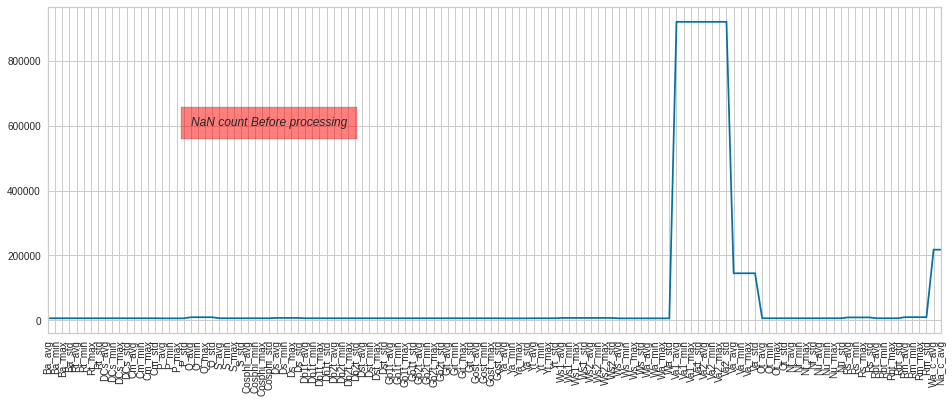

In [38]:
plt.figure(figsize=(16,6))
plt.plot(DF_combined.sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.text(20, 600000, 'NaN count Before processing', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

<font size="6"> [1.2] - Data Clean. </font>

According to the table, va1_avg and va2_avg has too many missing values. It must be dropped.
Wa_c_avg and Na_c_Avg considerably have a missing values. columns will not be dropped because these features are related to the wind and are very important.

<font color='blue'>      [P_avg Pmin P_max P_std Q_avg Q_min Q_max Q_std S_avg S_min S_max S_std Wa_c_avg Na_c_avg Va_avg Va_min]</font>

All of the readings from the wind turbine that equal to zero nmust be dropped. This is probably because the turbine is not functional or it is under maintenance and this data is not useful to train regression models. 

The dataset will have no missing data. Only average readings are used to develop the model. 
A data set is created by dropping columns different than average readings; also date time and turbine name columns are dropped because they are not relevant features. 

In [39]:
R80711=DF_R80711.dropna(subset=['P_avg', 'P_min','P_max','P_std','Q_avg','Q_min',
                                'Q_max','Q_std','S_avg','S_min','S_max','S_std',
                                'Wa_c_avg','Na_c_avg','Va_avg','Va_min','Va_max',
                                'Va_std'])
R80721=DF_R80721.dropna(subset=['P_avg', 'P_min','P_max','P_std','Q_avg','Q_min',
                                'Q_max','Q_std','S_avg','S_min','S_max','S_std',
                                'Wa_c_avg','Na_c_avg','Va_avg','Va_min','Va_max',
                                'Va_std'])
R80736=DF_R80736.dropna(subset=['P_avg', 'P_min','P_max','P_std','Q_avg','Q_min',
                                'Q_max','Q_std','S_avg','S_min','S_max','S_std',
                                'Wa_c_avg','Na_c_avg','Va_avg','Va_min','Va_max',
                                'Va_std'])
R80790=DF_R80790.dropna(subset=['P_avg', 'P_min','P_max','P_std','Q_avg','Q_min',
                                'Q_max','Q_std','S_avg','S_min','S_max','S_std',
                                'Wa_c_avg','Na_c_avg','Va_avg','Va_min','Va_max',
                                'Va_std'])

R80711=R80711.drop(columns=['Va1_avg', 'Va1_min','Va1_max','Va1_std','Va2_avg','Va2_min',
                     'Va2_max','Va2_std','Va_avg','Va_min','Va_max','Va_std'])
           
R80721=R80721.drop(columns=['Va1_avg', 'Va1_min','Va1_max','Va1_std','Va2_avg','Va2_min',
                     'Va2_max','Va2_std','Va_avg','Va_min','Va_max','Va_std'])
            
R80736=R80736.drop(columns=['Va1_avg', 'Va1_min','Va1_max','Va1_std','Va2_avg','Va2_min',
                     'Va2_max','Va2_std','Va_avg','Va_min','Va_max','Va_std'])
            
R80790=R80790.drop(columns=['Va1_avg', 'Va1_min','Va1_max','Va1_std','Va2_avg','Va2_min',
                     'Va2_max','Va2_std','Va_avg','Va_min','Va_max','Va_std'])

In [40]:
DF_R80711_TB=R80711.isnull().sum()
DF_R80721_TB=R80721.isnull().sum()
DF_R80736_TB=R80736.isnull().sum()
DF_R80790_TB=R80790.isnull().sum()

In [41]:
DF = pd.concat([DF_R80711_TB, DF_R80721_TB,DF_R80736_TB,DF_R80790_TB], axis=1, join="inner")
DF_combined=DF.transpose()
DF_combined.index=['R80711', 'R80721','R80736','R80790']

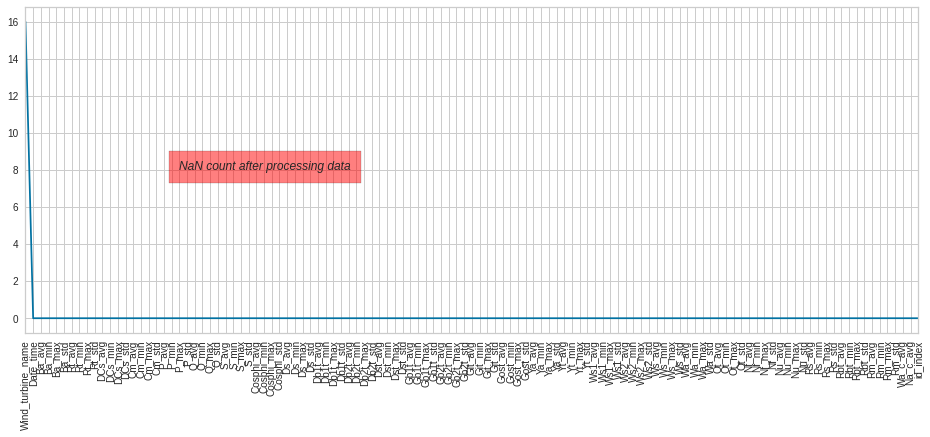

In [42]:
plt.figure(figsize=(16,6))
plt.plot(DF_combined.sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.text(20, 8, 'NaN count after processing data', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

In [12]:
DF = pd.concat([R80711,R80721,R80736,R80790])

In [13]:
df=pd.DataFrame(DF,columns=['Ba_avg','Rt_avg','DCs_avg','Cm_avg','P_avg',
                            'Q_avg','S_avg','Cosphi_avg','Ds_avg','Db1t_avg',
                            'Db2t_avg','Dst_avg','Gb1t_avg','Gb2t_avg','Git_avg',
                            'Gost_avg','Ya_avg','Yt_avg','Ws1_avg','Ws2_avg',
                            'Ws_avg','Wa_avg','Ot_avg','Nf_avg','Nu_avg','Rs_avg',
                            'Rbt_avg','Rm_avg','Wa_c_avg','Na_c_avg'])

<font size="6"> [1.3] - Data Preparing. </font> 

Sliding window.
The dataset must be prepared in a sliding window format for the model to make predcitions. 
Class below prepares data

In [14]:
class classifier_data:
    def __init__(self, data, targets, time_horizon):
        self.data = data
        self.targets = targets
        self.time_horizon = time_horizon
        self.get_targets()
        self.output = self.data_shift()

    def data_shift(self):
        lagged_features = self.data.iloc[:, self.get_targets()]
        lagged_features = lagged_features.shift(self.time_horizon, axis=0)
        lagged_features = lagged_features.add_suffix('_target')
        data_formatted = pd.concat([self.data, lagged_features], axis=1)
        data_formatted.drop(df.index[:self.time_horizon], inplace=True)
        data_formatted.drop(df.columns[self.get_targets()], axis = 1, inplace = True)

        return data_formatted

    
    def get_targets(self):
        targets = self.targets
        if "-" in targets:
            x, y = map(int, targets.split("-"))
            output = [*range(x, y+1)]
        elif "," in targets:
            output = list(map(int, targets.split(",")))
        else:
            output = ""
        return output

In [16]:
new_dframe=classifier_data(df,"4-6",10).output

In [17]:
X=new_dframe.drop(['P_avg_target','Q_avg_target','S_avg_target'], axis=1)
Y=pd.DataFrame(new_dframe,columns=['P_avg_target','Q_avg_target','S_avg_target'])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, 
                                                    random_state=42, shuffle=False)

In [19]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

XGBoost gradient boosted implementation for Python can only train models with a single target output.
A way to workaround this is to use XGB Regressor from scikit learn as a wrapper and use it as MultiOutput Regressor.

In [20]:
model = MultiOutputRegressor(xgb.XGBRegressor(max_depth=6, n_estimators=200, n_jobs=1,
                           objective='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.1)).fit(x_train, y_train)

In [21]:
tscv = TimeSeriesSplit(n_splits=3)
results = cross_val_score(model, x_train, y_train, cv=tscv)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 44.89% (4.32%)


The model performs poorly and unfortunately, with the model wrapper in a MultiOutputRegressor, it is not possible to run GridSearchCV for hyperparameter optimization. Each one of the the three targets must be trained individually. Individually, GridSearchCV will optimize hyperparameters. 

continuous-multioutput is not supported

In [22]:
X=new_dframe.drop(['P_avg_target','Q_avg_target','S_avg_target'], axis=1)
Y=pd.DataFrame(new_dframe,columns=['P_avg_target','Q_avg_target','S_avg_target'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, 
                                                    random_state=42, shuffle=False)

In [23]:
P_avg_target=pd.DataFrame(new_dframe,columns=['P_avg_target'])

Q_avg_target=pd.DataFrame(new_dframe,columns=['Q_avg_target'])

In [24]:
x_train, x_test, P_train, P_test = train_test_split(X, P_avg_target, test_size=0.1, 
                                                    random_state=42, shuffle=False)

x_train, x_test, Q_train, Q_test = train_test_split(X, Q_avg_target, test_size=0.1, 
                                                    random_state=42, shuffle=False)

In [26]:
print("Parameter optimization")

param_search={'max_depth': [2, 4, 6],'n_estimators': [50, 100, 200]}


param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model,param_search, verbose=1, n_jobs=1)
clf.fit(x_train, P_train)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.5325940079161751
{'max_depth': 4, 'n_estimators': 50}


Here is the new model with the proposed hyperparameters with only one target output.

In [44]:
model = xgb.XGBRegressor(max_depth=4, n_estimators=200, n_jobs=1,
                           objective='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05)

In [45]:
tscv = TimeSeriesSplit(n_splits=3)
results = cross_val_score(model, x_train, P_train, cv=tscv)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 51.06% (2.41%)



51.06% of accuracy is a good starting point for regression. The model can be deployed and tuned to have better inference.
The dataset timestamp is 10 minutes. An extension to this project could be using the standard deviation formula and extend the dataset to 60 more readings every minute
Good learning!
